## Generate Result Tables
- MCHAD
- CAC
- II
- Center Loss
- G-MCHAD
- G-Center
- G-CAC

In [258]:
import seaborn as sb
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import pandas as pd
from os.path import join

In [259]:
sb.set()
sb.set_style("whitegrid")
sb.set_context("paper")

In [260]:
# root folder for experiment run
root = "/home/ki/projects/work/mchad/logs/multiruns/complete/04/21/"

In [261]:
# map test cases
dataset_map = {
    "test_vs_uniformnoise": "Gauss",
    "test_vs_gaussiannoise": "Uniform",
    "test_vs_tinycrop": "Tiny Crop",
    "test_vs_tinyresize": "Tiny Resize",
    "test_vs_lsuncrop": "LSUN Crop",
    "test_vs_lsunresize": "LSUN Resize",
    "test_vs_textures": "Texture",
}

model_map = {
    "src.models.CAC": "CAC",
    "src.models.Softmax": "Softmax",
    "src.models.MCHAD": "MCHAD",
    "src.models.Center": "Center",
    "src.models.II": "II",
    "src.models.GCAC": "G-CAC",
    "src.models.GCenter": "G-Center",
}


train_dataset_map = {
    "src.datamodules.CIFAR10DataModule": "CIFAR10",
    "src.datamodules.SVHNDataModule": "SVHN",
    "src.datamodules.CIFAR100DataModule": "CIFAR100",
}

In [262]:
def convert(df, key="Distance", task="OSR"):
    """
    Get correct metrics from dataframe
    """
    df.rename(
        inplace=True,
        columns={
            "Accuracy/test": "Accuracy",
            f"{key}/{task}/AUROC/test": "AUROC",
            f"{key}/{task}/AUPR-IN/test": "AUPR-IN",
            f"{key}/{task}/AUPR-OUT/test": "AUPR-OUT",
            f"{key}/{task}/FPR@95TPR/test": "FPR95",
        },
    )

    return df

In [263]:
directories = []
directories += [f"./svhn/center/{i}" for i in range(21)]
directories += [f"./svhn/mchad/{i}" for i in range(21)]
directories += [f"./svhn/gmchad/{i}" for i in range(21)]
directories += [f"./svhn/gcenter/{i}" for i in range(21)]
directories += [f"./svhn/gcac/{i}" for i in range(21)]
directories += [f"./svhn/cac/{i}" for i in range(21)]
directories += [f"./svhn/ii/{i}" for i in range(21)]

directories += [f"./cifar100/mchad/{i}" for i in range(21)]
directories += [f"./cifar100/gmchad/{i}" for i in range(21)]
directories += [f"./cifar100/gcenter/{i}" for i in range(21)]
# directories += [f"./cifar100/gcac/{i}" for i in range(21)]
# directories += [f"./cifar100/cac/{i}" for i in range(21)]
# directories += [f"./cifar100/ii/{i}" for i in range(21)]
# directories += [f"./cifar100/center/{i}" for i in range(21)]


# del directories[directories.index("./cifar100/cac/13")]
directories += [f"./cifar10/mchad/{i}" for i in range(21)]
directories += [f"./cifar10/center/{i}" for i in range(21)]
directories += [f"./cifar10/gmchad/{i}" for i in range(21)]
directories += [f"./cifar10/gcenter/{i}" for i in range(21)]
directories += [f"./cifar10/gcac/{i}" for i in range(21)]
directories += [f"./cifar10/cac/{i}" for i in range(21)]
directories += [f"./cifar10/ii/{i}" for i in range(21)]

In [264]:


def get_training_set(datamodule):
    target = datamodule["_target_"]
    d = train_dataset_map.get(target)

    if not d:
        if target == "src.datamodules.MultiDatamodule":
            d = train_dataset_map.get(datamodule["module1"]["_target_"])

    if not d:
        print(datamodule)
    else:
        print(d)

    return d


def load(path):
    local_df = []

    df = pd.read_csv(join(path, "results.csv"))
    metrics = pd.read_csv(join(path, "csv/version_0/metrics.csv"))
    config = OmegaConf.load(join(path, "tb/version_0/hparams.yaml"))
    df["Dataset"] = get_training_set(config["datamodule"])
    df["Outliers"] = df["test_case_name"].apply(dataset_map.get)
    model = str(config["model"]["_target_"])

    if model == "src.models.CAC":
        df["Model"] = "CAC"
        df = convert(df, "Distance")
    elif model == "src.models.SoftMax":
        print("EB-OOD")
        df_ebm = df.copy(deep=True)
        df_ebm["Model"] = "EB-OOD"
        df_emb = convert(df_ebm, "EnergyBased")

        local_df.append(df_ebm)

        print("Softmax")
        df["Model"] = "Softmax"
        df = convert(df, "Softmax")

    elif model == "src.models.MCHAD":
        if config["model"]["weight_oe"] == 0.0:
            # print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "MCHAD"
        else:
            print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "G-MCHAD"

        df = convert(df)
    elif model == "src.models.Center":
        df["Model"] = "Center"
        df = convert(df, "Softmax")
    elif model == "src.models.IIModel":
        df["Model"] = "II"
        df = convert(df)
    elif model == "src.models.GCenter":
        df["Model"] = "G-Center"
        df = convert(df, key="Softmax")
    elif model == "src.models.GCAC":
        df["Model"] = "G-CAC"
        df = convert(df, key="Distance")
    else:
        raise Exception(f"UNKNOWN: {model}")

    local_df.append(df)
    return config, pd.concat(local_df), metrics

In [265]:
dfs = []

for d in directories:
    # filter(lambda x: "center" not in x and "cifar100/softmax/" not in x and "mchad-o" not in x, directories):
    path = join(root, d)
    config, df, metrics = load(path)
    try:
        if df is not None:
            print(path)
            print(
                f"{df['Dataset'][0]}/{df['Model'][0]} -> {df['AUROC'].mean()} {len(df)}"
            )
            df = df[
                [
                    "Accuracy",
                    "AUROC",
                    "AUPR-IN",
                    "AUPR-OUT",
                    "FPR95",
                    "Dataset",
                    "Outliers",
                    "Model",
                ]
            ]
            dfs.append(df.copy())
    except Exception as e:
        print("EXCEPTION WHILE LOADING")
        print(type(e), e)
        print(df.columns)

df = pd.concat(dfs)

SVHN
/home/ki/projects/work/mchad/logs/multiruns/complete/04/21/./svhn/center/0
SVHN/Center -> 0.984665504523686 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/complete/04/21/./svhn/center/1
SVHN/Center -> 0.9738017235483442 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/complete/04/21/./svhn/center/2
SVHN/Center -> 0.9481713431222099 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/complete/04/21/./svhn/center/3
SVHN/Center -> 0.9852985058512006 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/complete/04/21/./svhn/center/4
SVHN/Center -> 0.9858072144644601 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/complete/04/21/./svhn/center/5
SVHN/Center -> 0.9890762908118111 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/complete/04/21/./svhn/center/6
SVHN/Center -> 0.9730758156095233 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/complete/04/21/./svhn/center/7
SVHN/Center -> 0.9826154283114842 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/complete/04/21/./svhn/ce

In [266]:
df["AUROC"] = df["AUROC"].apply(lambda x: x * 100)
df["AUPR-IN"] = df["AUPR-IN"].apply(lambda x: x * 100)
df["AUPR-OUT"] = df["AUPR-OUT"].apply(lambda x: x * 100)
df["FPR95"] = df["FPR95"].apply(lambda x: x * 100)
df["Accuracy"] = df["Accuracy"].apply(lambda x: x * 100)

In [267]:
# , "Tiny Crop", "LSUN Crop"
df = df[df["Outliers"].isin(["Texture", "Tiny Resize", "LSUN Resize", "Uniform", "Gaussian"])]
df = df.set_index(["Dataset", "Outliers", "Model"]).dropna()


In [268]:
from itertools import product
datasets = ["SVHN", "CIFAR10", "CIFAR100"]
# models = ["CAC", "II", "Center", "Softmax", "EB-OOD", "MCHAD", "G-MCHAD"]
models = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]

t =  df.reset_index().groupby(by=["Dataset", "Model"]).agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    ).reindex(list(product(datasets, models)))

s = t.to_latex(
        float_format="%.2f",
        multirow=True,
        escape=False,
        label="tab:results",
        # bold_rows="True",
    )

repl = {
    "mean": "Mean",
    "sem": "$\\pm \sigma_{\\bar{x}}$",
    " MCHAD": " \\textbf{MCHAD (ours)}",
    "G-MCHAD": "\\textbf{G-MCHAD (ours)}",
    "G-Center": "\\textbf{G-Center (ours)}",
    "G-CAC": "\\textbf{G-CAC (ours)}",
}

for k, v in repl.items():
    s = s.replace(k, v)

print(s)

\begin{table}
\centering
\label{tab:results}
\begin{tabular}{llrrrrrrrrrr}
\toprule
         &       & \multicolumn{2}{l}{Accuracy} & \multicolumn{2}{l}{AUROC} & \multicolumn{2}{l}{AUPR-IN} & \multicolumn{2}{l}{AUPR-OUT} & \multicolumn{2}{l}{FPR95} \\
         &       &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ &    Mean &  $\pm \sigma_{\bar{x}}$ &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ \\
Dataset & Model &          &      &       &      &         &      &          &      &       &      \\
\midrule
\multirow{7}{*}{SVHN} & \textbf{MCHAD (ours)} &    94.23 & 0.06 & 97.27 & 0.19 &   99.17 & 0.07 &    86.39 & 0.79 & 11.54 & 1.39 \\
         & II &    10.44 & 0.13 & 51.44 & 1.87 &   76.40 & 1.20 &    28.65 & 1.48 & 92.91 & 1.54 \\
         & CAC &    94.04 & 0.04 & 93.52 & 0.45 &   96.21 & 0.30 &    83.36 & 0.98 & 24.80 & 2.09 \\
         & Center &    94.35 & 0.05 & 98.01 & 0.15 &   99.32 & 0.05 &    93.41 & 0.52 & 10.41 & 0.88 \\
  

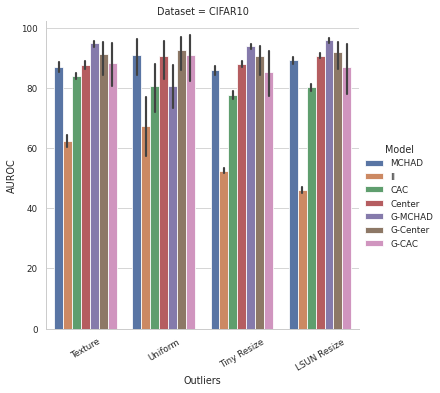

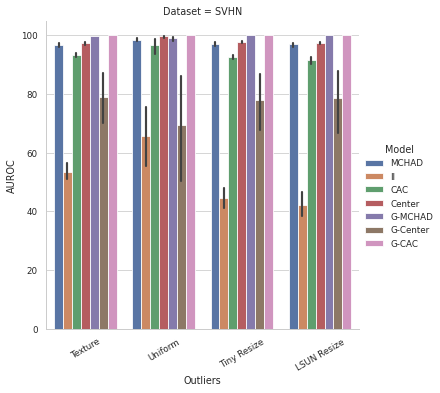

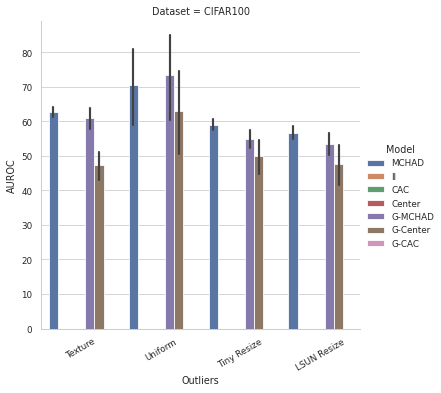

In [269]:
methods = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]

for dataset in ["CIFAR10", "SVHN", "CIFAR100"]:
    g = sb.catplot(
        data=df.reset_index()[df.reset_index()["Dataset"] == dataset],
        x="Outliers",
        y="AUROC",
        kind="bar",
        hue="Model",
        col="Dataset",
        hue_order=methods
    )
    g.set_xticklabels(rotation=30)
    plt.savefig(f"out/single-auroc-{dataset}.png", dpi=300)
    plt.show()

In [270]:
tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")| (tmp["Model"] == "G-CAC") | (tmp["Model"] == "G-Center")]

print(
    tmp
    .groupby(by=["Dataset", "Model"])
    .agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    )
    .to_html(
        float_format="%.2f",
        escape=False,
    )
)


<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="2" halign="left">Accuracy</th>
      <th colspan="2" halign="left">AUROC</th>
      <th colspan="2" halign="left">AUPR-IN</th>
      <th colspan="2" halign="left">AUPR-OUT</th>
      <th colspan="2" halign="left">FPR95</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
    </tr>
    <tr>
      <th>Dataset</th>
      <th>Model</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="7" valign="top">CIFAR10</th>
      <th>CAC</th>
      <td>93.52</td>
      <td>0.05</td>
      <td>80.60</td>
      <td>1.13</td>
      <td>8

In [271]:
tmp.groupby(by=["Dataset", "Model"]).agg(
    {
        "Accuracy": ["mean", "sem"],
        "AUROC": ["mean", "sem"],
        "AUPR-IN": ["mean", "sem"],
        "AUPR-OUT": ["mean", "sem"],
        "FPR95": ["mean", "sem"],
    }
)

Accuracy                AUROC              AUPR-IN  \
                        mean       sem       mean       sem       mean   
Dataset  Model                                                           
CIFAR10  CAC       93.517143  0.045949  80.600947  1.126906  80.213717   
         Center    93.134286  0.085133  89.179772  0.886308  92.163120   
         G-CAC     79.032857  2.809338  87.760975  1.996611  88.309471   
         G-Center  91.268571  0.864978  91.590328  1.489392  93.607060   
         G-MCHAD   92.803809  0.154025  91.196800  1.171995  93.795686   
         II        28.009524  0.174289  56.988695  1.575209  61.472513   
         MCHAD     92.897618  0.107383  88.218015  0.866323  90.119847   
CIFAR100 G-Center  48.739047  1.916750  51.933593  1.986363  60.896836   
         G-MCHAD   54.828572  1.260922  60.650891  1.926029  65.941848   
         MCHAD     62.721905  0.146597  62.322930  1.553571  66.840096   
SVHN     CAC       94.042132  0.039956  93.515093  0.448570  96.212378   
         Center    94.347250  0.054534  98.010349  0.145371  99.322966   
         G-CAC     92.764218  0.133500  99.985421  0.003855  99.995248   
         G-Center  93.911706  0.066715  76.190115  3.160862  86.846128   
         G-MCHAD   94.262922  0.058199  99.655938  0.096486  99.902038   
         II        10.440996  0.126153  51.441787  1.870413  76.404759   
         MCHAD     94.231093  0.058949  97.272466  0.187216  99.165207   

                              AUPR-OUT                FPR95            
                        sem       mean       sem       mean       sem  
Dataset  Model                                                         
CIFAR10  CAC       1.165871  76.515315  1.149136  65.519819  2.376669  
         Center    0.625918  84.030750  1.076825  53.789473  2.821657  
         G-CAC     1.857797  86.831864  2.127343  29.096655  3.821088  
         G-Center  1.270526  88.075035  1.408781  38.137127  2.801837  
         G-MCHAD   0.716486  87.739207  1.484180  37.977055  3.302983  
         II        1.665735  53.335506  1.378700  87.783494  2.163454  
         MCHAD     0.692013  82.352111  1.171833  53.001247  2.946391  
CIFAR100 G-Center  1.675718  49.689220  1.630668  91.371792  1.713011  
         G-MCHAD   1.744597  59.504860  1.764238  77.290834  3.017923  
         MCHAD     1.514699  59.471577  1.226662  83.900865  1.374544  
SVHN     CAC       0.298767  83.361035  0.979132  24.795436  2.089604  
         Center    0.049729  93.410114  0.518394  10.406126  0.877149  
         G-CAC     0.001267  99.947100  0.017200   0.047459  0.013080  
         G-Center  1.756718  65.139366  2.858665  48.422640  3.906675  
         G-MCHAD   0.027877  97.842968  0.569975   1.706678  1.233376  
         II        1.200057  28.648691  1.480681  92.914424  1.542211  
         MCHAD     0.065272  86.392173  0.794098  11.538349  1.389599

In [272]:
from scipy.stats import ttest_ind

tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")]

for metric in ["Accuracy", "AUROC", "AUPR-IN", "AUPR-OUT", "FPR95"]:
    for dataset in ["SVHN", "CIFAR10", "CIFAR100"]:
        a = tmp[(tmp["Model"] == "CAC") & (tmp["Dataset"] == dataset)][metric]
        b = tmp[(tmp["Model"] == "MCHAD") & (tmp["Dataset"]== dataset)][metric]
        stat, p = ttest_ind(a,b, equal_var=False)
        print(f"{metric} {dataset} -> {p < 0.05} ")

Accuracy SVHN -> True 
Accuracy CIFAR10 -> True 
Accuracy CIFAR100 -> False 
AUROC SVHN -> True 
AUROC CIFAR10 -> True 
AUROC CIFAR100 -> False 
AUPR-IN SVHN -> True 
AUPR-IN CIFAR10 -> True 
AUPR-IN CIFAR100 -> False 
AUPR-OUT SVHN -> True 
AUPR-OUT CIFAR10 -> True 
AUPR-OUT CIFAR100 -> False 
FPR95 SVHN -> True 
FPR95 CIFAR10 -> True 
FPR95 CIFAR100 -> False 
